<a href="https://colab.research.google.com/github/sreeyadora/Brain_Tumor_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Path to data
data_dir = "archive (4).zip"
# The dataset has 'yes' and 'no' folder

In [4]:
import zipfile
import os

# Unzip if not already extracted
if not os.path.exists("brain_tumor_dataset"):
    with zipfile.ZipFile("archive (4).zip", 'r') as zip_ref:
        zip_ref.extractall(".")

# Detect main folder
if os.path.exists("yes") and os.path.exists("no"):
    data_dir = "."
elif os.path.exists("brain_tumor_dataset/yes"):
    data_dir = "brain_tumor_dataset"
else:
    for root, dirs, files in os.walk("."):
        if 'yes' in dirs and 'no' in dirs:
            data_dir = root
            break

print("Data directory:", data_dir)

# Now run your splitting function
if not os.path.exists("data_split"):
    create_split_folders(data_dir, "data_split", test_size=0.2)

Data directory: .


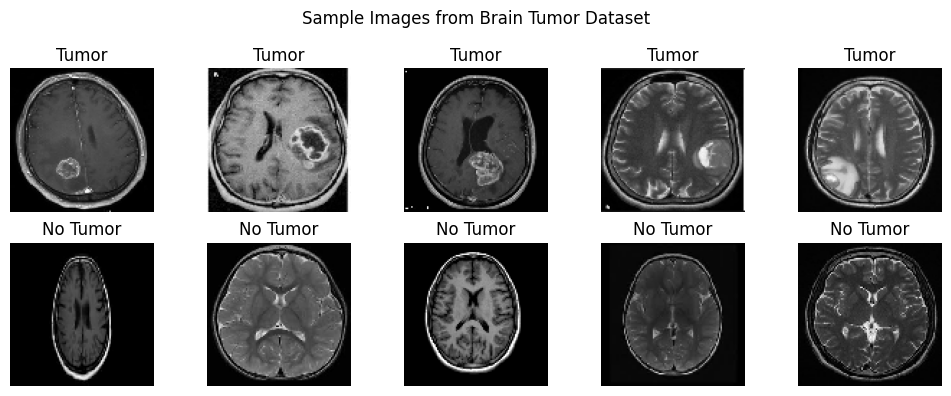

In [18]:
# Paths to tumor and non-tumor images
yes_dir = 'data_split/train/yes'
no_dir = 'data_split/train/no'

# Get some sample image paths from each class
yes_images = [os.path.join(yes_dir, fname) for fname in os.listdir(yes_dir) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
no_images = [os.path.join(no_dir, fname) for fname in os.listdir(no_dir) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]

# Display images
plt.figure(figsize=(10, 4))
for i, img_path in enumerate(yes_images + no_images):
    img = image.load_img(img_path, target_size=(100, 100))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Tumor' if i < 5 else 'No Tumor')
plt.suptitle("Sample Images from Brain Tumor Dataset")
plt.tight_layout()
plt.show()

In [5]:
# Split data into train and validation sets
import shutil
from sklearn.model_selection import train_test_split

def create_split_folders(input_dir, output_base, test_size=0.2):
    for category in ['yes', 'no']:
        images = os.listdir(os.path.join(input_dir, category))
        train_imgs, val_imgs = train_test_split(images, test_size=test_size, random_state=42)
        for split, split_imgs in [('train', train_imgs), ('val', val_imgs)]:
            split_folder = os.path.join(output_base, split, category)
            os.makedirs(split_folder, exist_ok=True)
            for img in split_imgs:
                shutil.copy(os.path.join(input_dir, category, img), split_folder)

if not os.path.exists("data_split"):
    create_split_folders(data_dir, "data_split", test_size=0.2)


In [6]:
# Image data generators
img_height, img_width = 150, 150
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "data_split/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    "data_split/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [7]:
# 3. Build CNN Model
# =======================

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 4. Train the Model
# =======================

epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6587 - loss: 0.6664

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6537 - loss: 0.6680 - val_accuracy: 0.7059 - val_loss: 0.6141
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6716 - loss: 0.6390 - val_accuracy: 0.7059 - val_loss: 0.5805
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6584 - loss: 0.6199 - val_accuracy: 0.6863 - val_loss: 0.5582
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7187 - loss: 0.5974 - val_accuracy: 0.7451 - val_loss: 0.5511
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7149 - loss: 0.5780 - val_accuracy: 0.7647 - val_loss: 0.5472
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7297 - loss: 0.5751 - val_accuracy: 0.7647 - val_loss: 0.5330
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7504 - loss: 0.5512 - val_accuracy: 0.7647 - val_loss: 0.5416
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7282 - loss: 0.5655 - val_accuracy: 0.7647 - val_loss: 0.5328
Epoch 9/10
7/7 ━━━━

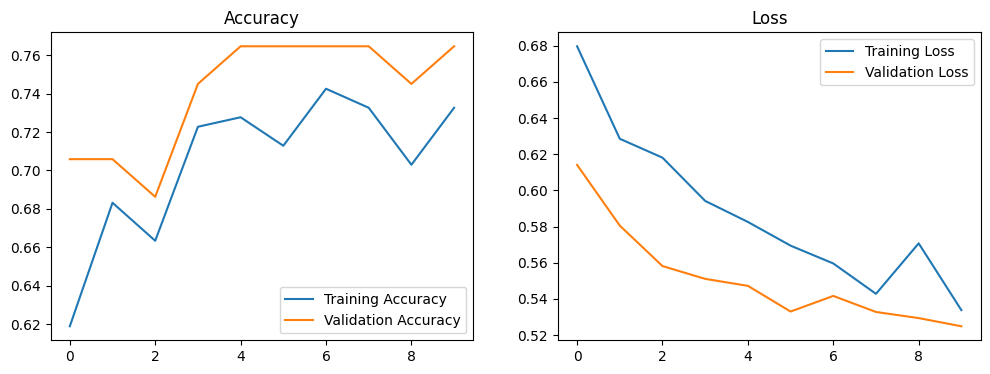

In [9]:
# 5. Evaluate & Visualize
# =======================

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


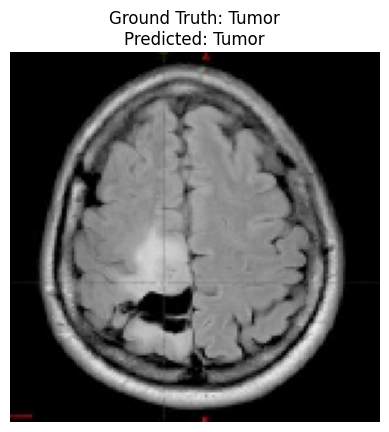

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os

val_yes_dir = 'data_split/val/yes'
val_no_dir = 'data_split/val/no'

if os.listdir(val_yes_dir):
    img_path = os.path.join(val_yes_dir, os.listdir(val_yes_dir)[0])
    label = "Tumor"
elif os.listdir(val_no_dir):
    img_path = os.path.join(val_no_dir, os.listdir(val_no_dir)[0])
    label = "No Tumor"
else:
    raise ValueError("No validation images found in either class!")

img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_label = "Tumor" if prediction[0][0] > 0.5 else "No Tumor"

plt.imshow(img)
plt.axis('off')
plt.title(f"Ground Truth: {label}\nPredicted: {predicted_label}")
plt.show()

In [22]:
# For training data
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step - accuracy: 0.8036 - loss: 0.4560
Training Accuracy: 0.7921


In [24]:
# Calculate and print accuracy for validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

# Training accuracy
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.7937 - loss: 0.5187
Validation Accuracy: 0.7843
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.7733 - loss: 0.4705
Training Accuracy: 0.7723


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


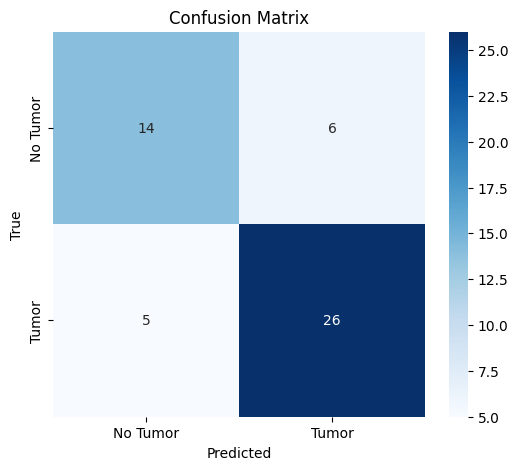

              precision    recall  f1-score   support

    No Tumor       0.74      0.70      0.72        20
       Tumor       0.81      0.84      0.83        31

    accuracy                           0.78        51
   macro avg       0.77      0.77      0.77        51
weighted avg       0.78      0.78      0.78        51



In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get all validation images and labels
val_generator.reset()
y_true = []
y_pred = []

for i in range(len(val_generator)):
    images, labels = val_generator[i]
    preds = model.predict(images)
    y_true.extend(labels)
    y_pred.extend([1 if p > 0.5 else 0 for p in preds.flatten()])

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["No Tumor", "Tumor"]

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))